In [318]:
import matplotlib.pyplot as plt
import subprocess
import sys
sys.path.append("../")
from utils import createXYPlot
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
df_vax = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv")

In [228]:
df_vax.columns

Index(['data_somministrazione', 'fornitore', 'area', 'fascia_anagrafica',
       'sesso_maschile', 'sesso_femminile', 'prima_dose', 'seconda_dose',
       'pregressa_infezione', 'dose_addizionale_booster', 'codice_NUTS1',
       'codice_NUTS2', 'codice_regione_ISTAT', 'nome_area'],
      dtype='object')

In [229]:
fornitori = sorted(df_vax.fornitore.unique())
anagrafiche = sorted(df_vax.fascia_anagrafica.unique())

In [230]:
oggi = np.max(df_vax["data_somministrazione"])
plots_folder = f"./plots/{oggi}/vaccination"
print(plots_folder)
res = subprocess.check_output(f"mkdir -p {plots_folder}",shell=True)

./plots/2022-01-20/vaccination


In [231]:
def group_by_doses(df, keys, columns):
    agg_dict = {c:"sum" for c in columns}
    df = df.groupby(keys).agg(agg_dict).reset_index()
    return df

In [232]:
def get_grid(keys):
    grid = pd.DataFrame()
    for f in keys:
        new_grid = pd.DataFrame(df_vax[f].unique(), columns=[f])
        new_grid['key'] = 0
        grid['key'] = 0
        grid = grid.merge(new_grid, on='key', how='outer')
    grid = grid.sort_values(by=keys).reset_index(drop=True)
    return grid.drop(["key"],axis=1)

In [233]:
df_vax_yyyy_mm_dd.columns

Index(['data_somministrazione', 'prima_dose', 'seconda_dose', 'terza_dose',
       'pregressa_infezione', 'prima_dose_no_guariti', 'prima_dose_pediatrico',
       'seconda_dose_pediatrico', 'terza_dose_pediatrico',
       'pregressa_infezione_pediatrico', 'prima_dose_no_guariti_pediatrico',
       'prima_dose_adulti', 'seconda_dose_adulti', 'terza_dose_adulti',
       'prima_dose_media_7', 'seconda_dose_media_7', 'terza_dose_media_7',
       'prima_dose_no_guariti_media_7', 'prima_dose_pediatrico_media_7',
       'seconda_dose_pediatrico_media_7', 'terza_dose_pediatrico_media_7',
       'prima_dose_no_guariti_pediatrico_media_7', 'prima_dose_adulti_media_7',
       'seconda_dose_adulti_media_7', 'terza_dose_adulti_media_7'],
      dtype='object')

In [234]:
def roll_mean(df, key=None):
    df = df.set_index("data_somministrazione")
    col_names = [c for c in df.columns if "dose" in c]
    print(col_names)
    for cname in col_names:
        if key is not None:
            df_roll = pd.DataFrame(df.groupby(key)[cname].rolling(7).mean())
            df_roll = df_roll.rename(columns={cname: f"{cname}_media_7"})
            for k in key:
                df = df.set_index(k, append=True)
            df = df.join(df_roll).reset_index().set_index("data_somministrazione")
        else:
            df[f"{cname}_media_7"] = df[cname].rolling(7).mean()
    
    return df.reset_index()

In [235]:
df_vax["terza_dose"] = df_vax["dose_addizionale_booster"]
df_vax["prima_dose_no_guariti"] = df_vax["prima_dose"]
df_vax["prima_dose"] = df_vax["prima_dose"] + df_vax["pregressa_infezione"]

In [236]:
cols_to_sum = ["prima_dose", "seconda_dose", "terza_dose", "pregressa_infezione", "prima_dose_no_guariti"]
df_vax_yyyy_mm_dd = group_by_doses(df_vax, keys=["data_somministrazione"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fornitore"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica", "fornitore"], columns=cols_to_sum)

In [237]:
pd.DataFrame(df_vax_yyyy_mm_dd[["prima_dose",
                                "seconda_dose",
                                "terza_dose",
                                "pregressa_infezione",
                                "prima_dose_no_guariti"
                               ]].agg(sum),columns=["totale"])

totale
prima_dose             49674956
seconda_dose           44042121
terza_dose             29002472
pregressa_infezione     1707337
prima_dose_no_guariti  47967619

In [238]:
df_vax_yyyy_mm_dd_pediatrico=df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Pfizer Pediatrico"].drop(columns="fornitore")
df_vax_yyyy_mm_dd = df_vax_yyyy_mm_dd.merge(df_vax_yyyy_mm_dd_pediatrico, on="data_somministrazione", how="left", suffixes=("","_pediatrico"))
for n_dos in ["prima", "seconda", "terza"]:
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose"] - df_vax_yyyy_mm_dd[f"{n_dos}_dose_pediatrico"]
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"].combine_first(df_vax_yyyy_mm_dd[f"{n_dos}_dose"])
    
    
    

In [239]:
df_vax_yyyy_mm_dd

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
0              2020-12-27        7346             0           0   
1              2020-12-28        1503             0           0   
2              2020-12-29        1119             0           0   
3              2020-12-30        4868             0           0   
4              2020-12-31       25934             0           0   
..                    ...         ...           ...         ...   
385            2022-01-16       65686         26311      338838   
386            2022-01-17       58683         49730      485869   
387            2022-01-18       59161         53190      511900   
388            2022-01-19       54376         51870      493902   
389            2022-01-20       52675         53484      475181   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_pediatrico  \
0                     15                   7331                    NaN   
1                      2                   1501                    NaN   
2                      1                   1118                    NaN   
3                      2                   4866                    NaN   
4                     34                  25900                    NaN   
..                   ...                    ...                    ...   
385                 1304                  64382                42448.0   
386                 1744                  56939                21420.0   
387                 1762                  57399                22275.0   
388                 1830                  52546                20468.0   
389                 1664                  51011                20025.0   

     seconda_dose_pediatrico  terza_dose_pediatrico  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   
..                       ...                    ...   
385                   9857.0                    0.0   
386                  18165.0                    0.0   
387                  22715.0                    0.0   
388                  24204.0                    0.0   
389                  20654.0                    0.0   

     pregressa_infezione_pediatrico  prima_dose_no_guariti_pediatrico  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   
..                              ...                               ...   
385                           177.0                           42271.0   
386                            83.0                           21337.0   
387                            89.0                           22186.0   
388                            72.0                           20396.0   
389                            76.0                           19949.0   

     prima_dose_adulti  seconda_dose_adulti  terza_dose_adulti  
0               7346.0                  0.0                0.0  
1               1503.0                  0.0                0.0  
2               1119.0                  0.0                0.0  
3               4868.0                  0.0                0.0  
4              25934.0                  0.0                0.0  
..                 ...                  ...                ...  
385            23238.0              16454.0           338838.0  
386            37263.0              31565.0           485869.0  
387            36886.0              30475.0           511900.0  
388            33908.0              27666.0           493902.0  
389            32650.0              32830.0           475

In [240]:
df_vax_yyyy_mm_dd = roll_mean(df_vax_yyyy_mm_dd)
df_vax_yyyy_mm_dd_fornitore = roll_mean(df_vax_yyyy_mm_dd_fornitore,key=["fornitore"])
df_vax_yyyy_mm_dd_anag_fornitore = roll_mean(df_vax_yyyy_mm_dd_anag_fornitore,key=["fornitore","fascia_anagrafica"])
df_vax_yyyy_mm_dd_anag = roll_mean(df_vax_yyyy_mm_dd_anag, key=["fascia_anagrafica"])

['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti', 'prima_dose_pediatrico', 'seconda_dose_pediatrico', 'terza_dose_pediatrico', 'prima_dose_no_guariti_pediatrico', 'prima_dose_adulti', 'seconda_dose_adulti', 'terza_dose_adulti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']


In [241]:
df_vax_yyyy_mm_dd[["data_somministrazione","prima_dose","prima_dose_adulti","prima_dose_pediatrico"]]

data_somministrazione  prima_dose  prima_dose_adulti  \
0              2020-12-27        7346             7346.0   
1              2020-12-28        1503             1503.0   
2              2020-12-29        1119             1119.0   
3              2020-12-30        4868             4868.0   
4              2020-12-31       25934            25934.0   
..                    ...         ...                ...   
385            2022-01-16       65686            23238.0   
386            2022-01-17       58683            37263.0   
387            2022-01-18       59161            36886.0   
388            2022-01-19       54376            33908.0   
389            2022-01-20       52675            32650.0   

     prima_dose_pediatrico  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
..                     ...  
385                42448.0  
386                21420.0  
387                22275.0  
388                20468.0  
389                20025.0  

[390 rows x 4 columns]

In [242]:
fornitori = df_vax_yyyy_mm_dd_fornitore["fornitore"].unique()

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


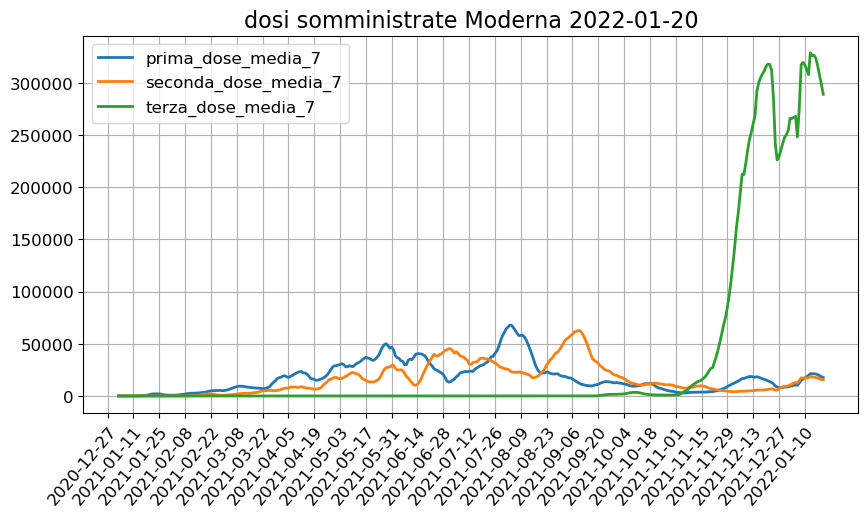

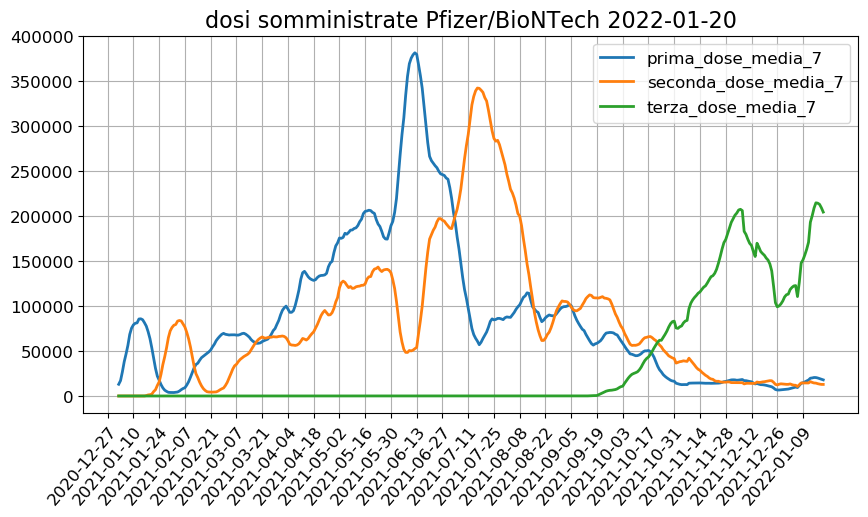

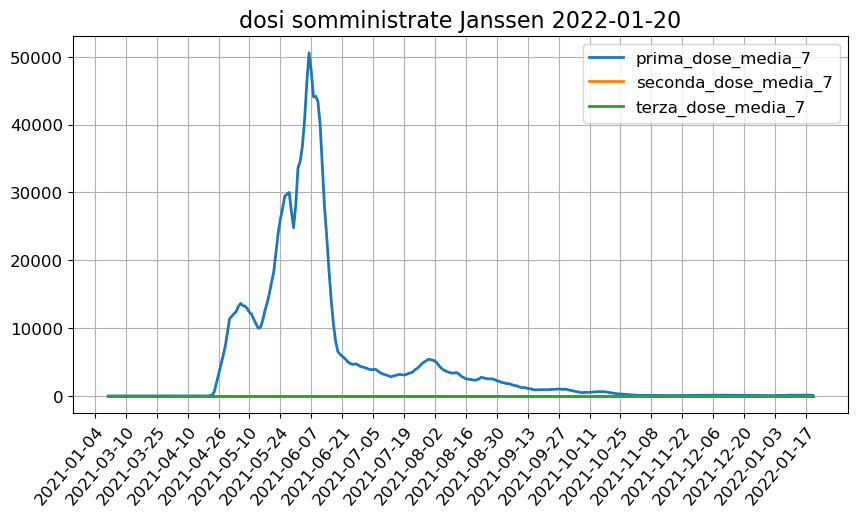

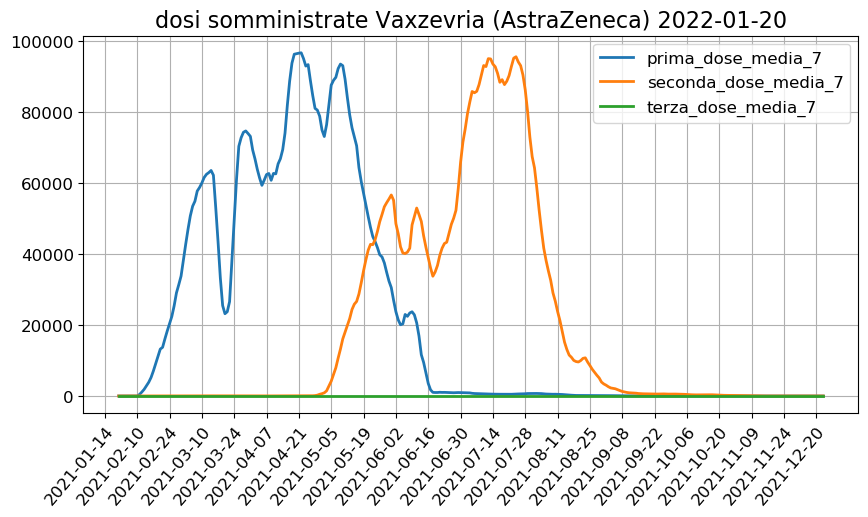

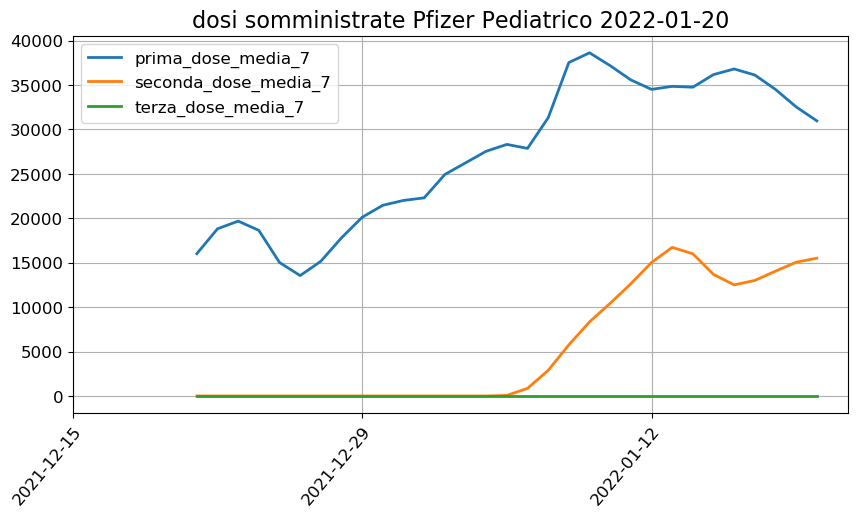

In [243]:
for fornitore in fornitori:
    savename_suffix="_"+fornitore.replace("/","_")
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    df_plot["prima_dose_media_7"] = df_plot["prima_dose"].rolling(7).mean()
    df_plot["seconda_dose_media_7"] = df_plot["seconda_dose"].rolling(7).mean()
    df_plot["terza_dose_media_7"] = df_plot["terza_dose"].rolling(7).mean()
    createXYPlot(df_plot, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")

In [244]:
df_vax_yyyy_mm_dd.tail(15)

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
375            2022-01-06       46586         19470      273956   
376            2022-01-07       76800         56557      553412   
377            2022-01-08       83946         53553      502122   
378            2022-01-09       64184         37247      319049   
379            2022-01-10       70713         54821      539970   
380            2022-01-11       82601         55006      585440   
381            2022-01-12       79735         51661      577922   
382            2022-01-13       74407         52119      576568   
383            2022-01-14       78139         40357      584853   
384            2022-01-15       97627         31858      564122   
385            2022-01-16       65686         26311      338838   
386            2022-01-17       58683         49730      485869   
387            2022-01-18       59161         53190      511900   
388            2022-01-19       54376         51870      493902   
389            2022-01-20       52675         53484      475181   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_pediatrico  \
375                  876                  45710                28663.0   
376                 1700                  75100                34607.0   
377                 1511                  82435                46216.0   
378                 1131                  63053                38019.0   
379                 1737                  68976                26198.0   
380                 1865                  80736                33637.0   
381                 1847                  77888                34221.0   
382                 1792                  72615                31030.0   
383                 1921                  76218                33956.0   
384                 2014                  95613                56149.0   
385                 1304                  64382                42448.0   
386                 1744                  56939                21420.0   
387                 1762                  57399                22275.0   
388                 1830                  52546                20468.0   
389                 1664                  51011                20025.0   

     seconda_dose_pediatrico  terza_dose_pediatrico  \
375                   5553.0                    0.0   
376                  14169.0                    0.0   
377                  20111.0                    0.0   
378                  18081.0                    0.0   
379                  14660.0                    0.0   
380                  15391.0                    0.0   
381                  17172.0                    0.0   
382                  17486.0                    0.0   
383                   9131.0                    0.0   
384                   3835.0                    0.0   
385                   9857.0                    0.0   
386                  18165.0                    0.0   
387                  22715.0                    0.0   
388                  24204.0                    0.0   
389                  20654.0                    0.0   

     pregressa_infezione_pediatrico  ...  seconda_dose_media_7  \
375                            55.0  ...          23894.000000   
376                            70.0  ...          30282.571429   
377                            99.0  ...          37507.857143   
378                            95.0  ...          40153.142857   
379                            75.0  ...          42096.285714   
380                           108.0  ...          44351.714286   
381                            92.0  ...          46902.142857   
382                           104.0  ...          51566.285714   
383                           107.0  ...          49252.000000   
384                           189.0  ...          46152.714286   
385                           177.0  ...          44590.428571   
386                            83.0  ...          43863.142857   
387    

In [245]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [246]:
df_vax_yyyy_mm_dd

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
0              2020-12-27        7346             0           0   
1              2020-12-28        1503             0           0   
2              2020-12-29        1119             0           0   
3              2020-12-30        4868             0           0   
4              2020-12-31       25934             0           0   
..                    ...         ...           ...         ...   
385            2022-01-16       65686         26311      338838   
386            2022-01-17       58683         49730      485869   
387            2022-01-18       59161         53190      511900   
388            2022-01-19       54376         51870      493902   
389            2022-01-20       52675         53484      475181   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_pediatrico  \
0                     15                   7331                    NaN   
1                      2                   1501                    NaN   
2                      1                   1118                    NaN   
3                      2                   4866                    NaN   
4                     34                  25900                    NaN   
..                   ...                    ...                    ...   
385                 1304                  64382                42448.0   
386                 1744                  56939                21420.0   
387                 1762                  57399                22275.0   
388                 1830                  52546                20468.0   
389                 1664                  51011                20025.0   

     seconda_dose_pediatrico  terza_dose_pediatrico  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   
..                       ...                    ...   
385                   9857.0                    0.0   
386                  18165.0                    0.0   
387                  22715.0                    0.0   
388                  24204.0                    0.0   
389                  20654.0                    0.0   

     pregressa_infezione_pediatrico  ...  seconda_dose_media_7  \
0                               NaN  ...                   NaN   
1                               NaN  ...                   NaN   
2                               NaN  ...                   NaN   
3                               NaN  ...                   NaN   
4                               NaN  ...                   NaN   
..                              ...  ...                   ...   
385                           177.0  ...          44590.428571   
386                            83.0  ...          43863.142857   
387                            89.0  ...          43603.714286   
388                            72.0  ...          43633.571429   
389                            76.0  ...          43828.571429   

     terza_dose_media_7  prima_dose_no_guariti_media_7  \
0                   NaN                            NaN   
1                   NaN                            NaN   
2                   NaN                            NaN   
3                   NaN                            NaN   
4                   NaN                            NaN   
..                  ...                            ...   
385       538244.714286                   76632.571429   
386       530516.000000                   74913.000000   
387       520010.285714                   71579.142857   
388       508007.428571                   67958.857143   
389       493523.571429                   64872.571429   

     prima_dose_pediatrico_media_7  seconda_dose_pediatrico_media_7  \
0                              NaN                              NaN   
1                

In [300]:
np.sum(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione>"2021-12-26"][["prima_dose_adulti"]])

prima_dose_adulti    772105.0
dtype: float64

In [321]:
cond = (df_vax_yyyy_mm_dd_anag.data_somministrazione>"2021-12-26") & (df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])) 
    
display(df_vax_yyyy_mm_dd_anag[cond][["data_somministrazione","fascia_anagrafica","prima_dose"]])

np.sum(df_vax_yyyy_mm_dd_anag[cond][["prima_dose"]])

data_somministrazione fascia_anagrafica  prima_dose
3296            2021-12-27             50-59        2776
3297            2021-12-27             60-69        1730
3298            2021-12-27             70-79         985
3299            2021-12-27             80-89         405
3300            2021-12-27               90+          88
3306            2021-12-28             50-59        3161
3307            2021-12-28             60-69        1963
3308            2021-12-28             70-79        1163
3309            2021-12-28             80-89         569
3310            2021-12-28               90+         150
3316            2021-12-29             50-59        3200
3317            2021-12-29             60-69        2082
3318            2021-12-29             70-79        1252
3319            2021-12-29             80-89         606
3320            2021-12-29               90+         175
3326            2021-12-30             50-59        3367
3327            2021-12-30             60-69        2203
3328            2021-12-30             70-79        1340
3329            2021-12-30             80-89         630
3330            2021-12-30               90+         192
3336            2021-12-31             50-59        1673
3337            2021-12-31             60-69         981
3338            2021-12-31             70-79         515
3339            2021-12-31             80-89         251
3340            2021-12-31               90+          72
3346            2022-01-01             50-59         421
3347            2022-01-01             60-69         228
3348            2022-01-01             70-79         112
3349            2022-01-01             80-89          44
3350            2022-01-01               90+           7
3356            2022-01-02             50-59        1792
3357            2022-01-02             60-69         940
3358            2022-01-02             70-79         466
3359            2022-01-02             80-89         251
3360            2022-01-02               90+          47
3366            2022-01-03             50-59        4041
3367            2022-01-03             60-69        2411
3368            2022-01-03             70-79        1271
3369            2022-01-03             80-89         564
3370            2022-01-03               90+         153
3376            2022-01-04             50-59        4263
3377            2022-01-04             60-69        2689
3378            2022-01-04             70-79        1460
3379            2022-01-04             80-89         726
3380            2022-01-04               90+         193
3386            2022-01-05             50-59        3858
3387            2022-01-05             60-69        2416
3388            2022-01-05             70-79        1447
3389            2022-01-05             80-89         671
3390            2022-01-05               90+         214
3396            2022-01-06             50-59        2719
3397            2022-01-06             60-69        1594
3398            2022-01-06             70-79         787
3399            2022-01-06             80-89         370
3400            2022-01-06               90+          64
3406            2022-01-07             50-59        7087
3407            2022-01-07             60-69        4885
3408            2022-01-07             70-79        2825
3409            2022-01-07             80-89        1112
3410            2022-01-07               90+         271
3416            2022-01-08             50-59        6594
3417            2022-01-08             60-69        4645
3418            2022-01-08             70-79        2628
3419            2022-01-08             80-89        1107
3420            2022-01-08               90+         216
3426            2022-01-09             50-59        4980
3427            2022-01-09             60-69        3177
3428            2022-01-09             70-79        1619
3429            2022-01-09             80-89         691
3430           

prima_dose    317906
dtype: int64

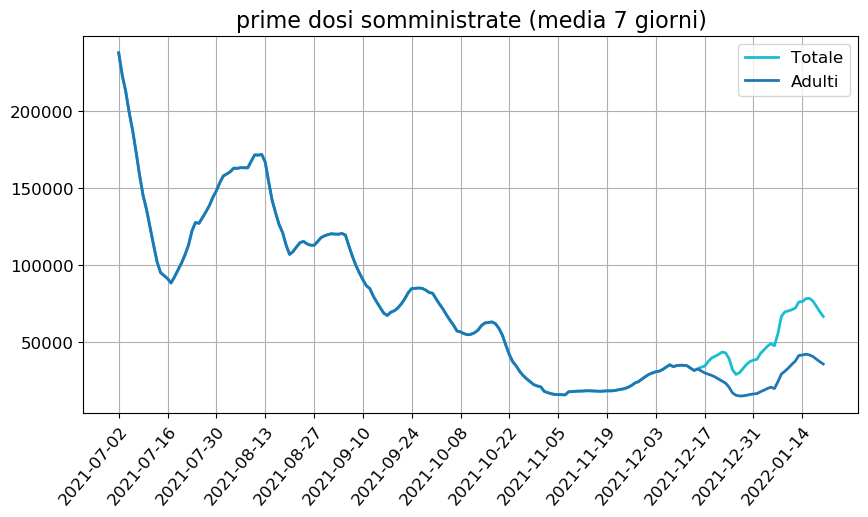

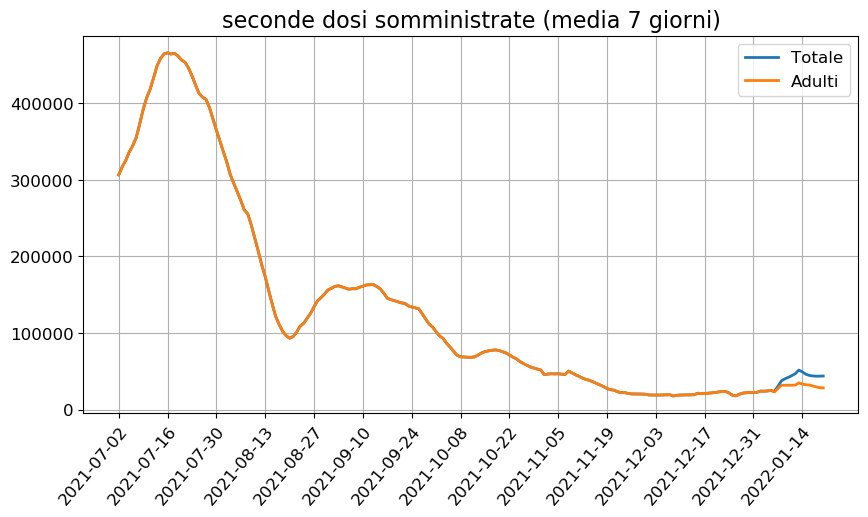

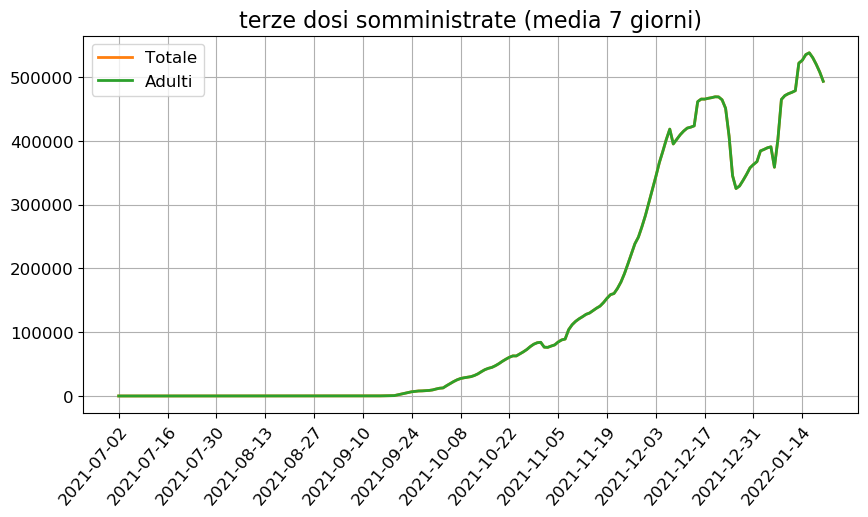

In [281]:
i = 0
for dose in ["prima","seconda","terza"]:
    
    createXYPlot(df_vax_yyyy_mm_dd, 
                 y=[
                    f"{dose}_dose_media_7",
                    f"{dose}_dose_adulti_media_7",
                    
                   ],
                 labels=["Totale","Adulti"],
                 colors=[colors[i-1],colors[i]],
                 alphas=[1,1],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 start_date="2021-07-01",
                 title=f"{dose.replace('a','e')} dosi somministrate (media 7 giorni)",
                 plots_folder=plots_folder,
                 savename=f"{dose.replace('a','e')}_dosi_somministrate.png"
                )
    i +=1

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


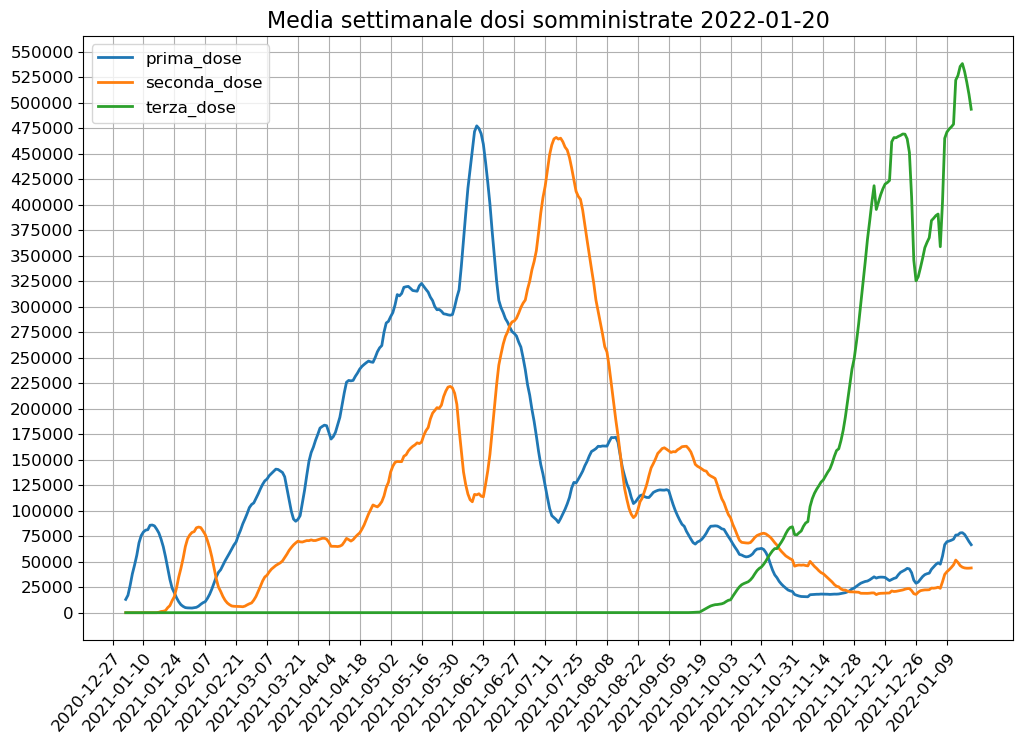

In [359]:
createXYPlot(df_vax_yyyy_mm_dd, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 labels=["prima_dose", "seconda_dose", "terza_dose"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"Media settimanale dosi somministrate {oggi}",
                 plots_folder=plots_folder,
                 yticks=range(0,575000,25000),
                 figsize_x=12,
                 figsize_y=8,
                 savename=f"dosi_somministrate_media7.png")

In [249]:
df_vax_yyyy_mm_dd["totale_prima_dose"] = df_vax_yyyy_mm_dd["prima_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_seconda_dose"] = df_vax_yyyy_mm_dd["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_terza_dose"] = df_vax_yyyy_mm_dd["terza_dose"].cumsum()

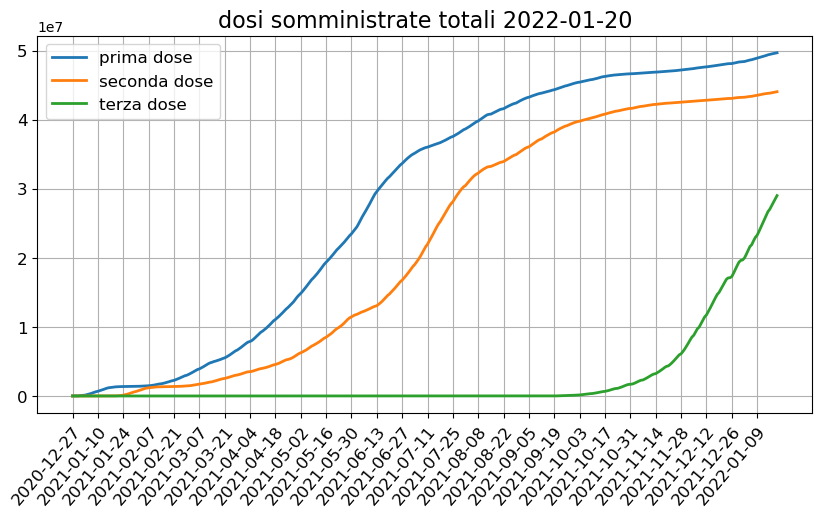

In [250]:
createXYPlot(df_vax_yyyy_mm_dd, 
             y=["totale_prima_dose","totale_seconda_dose", "totale_terza_dose"], 
             labels=["prima dose", "seconda dose", "terza dose"],
             x="data_somministrazione", 
             days_interval=14,
             linewidth=2,
             title=f"dosi somministrate totali {oggi}",
             plots_folder=plots_folder,
             savename=f"dosi_somministrate_cumulativo.png"
            )

### Cumulativa per fornitore

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


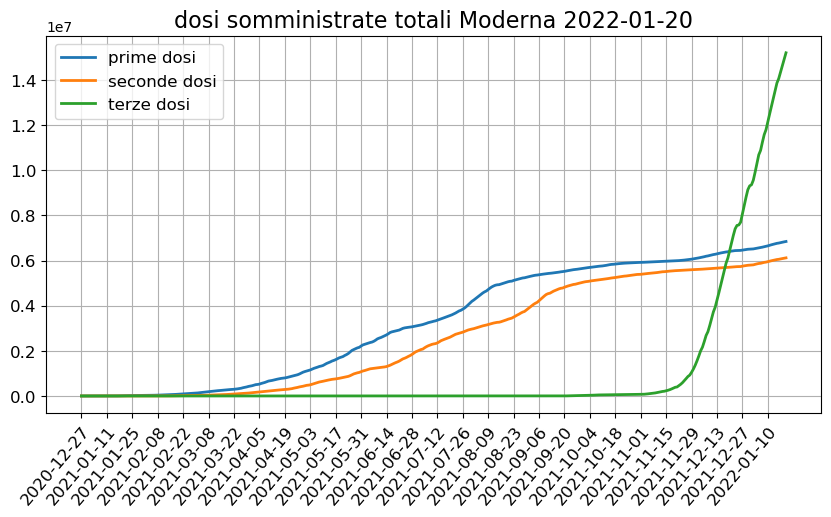

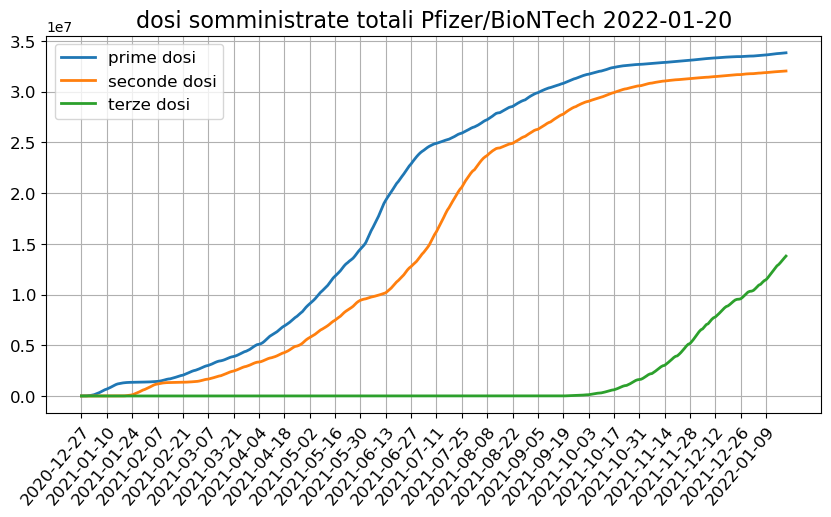

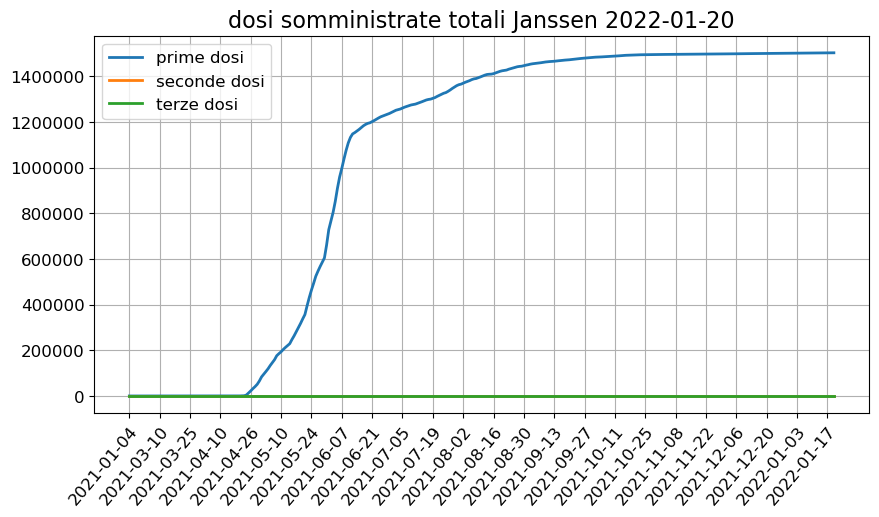

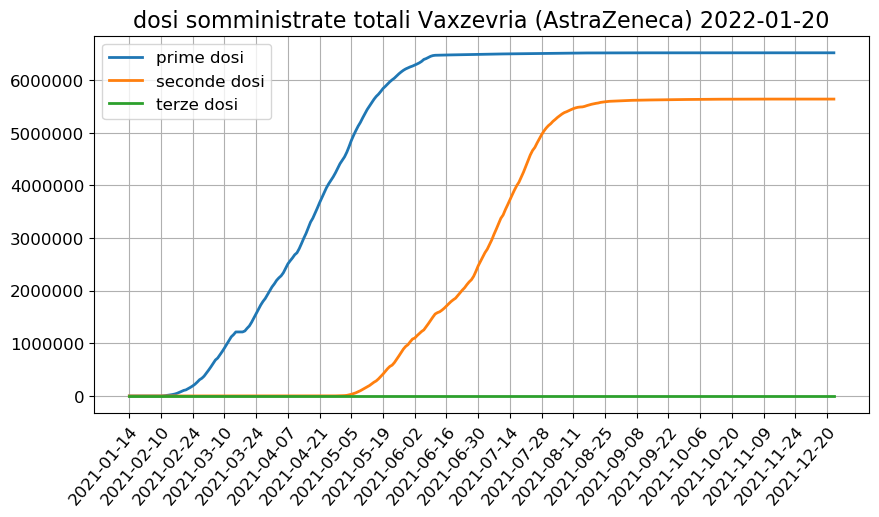

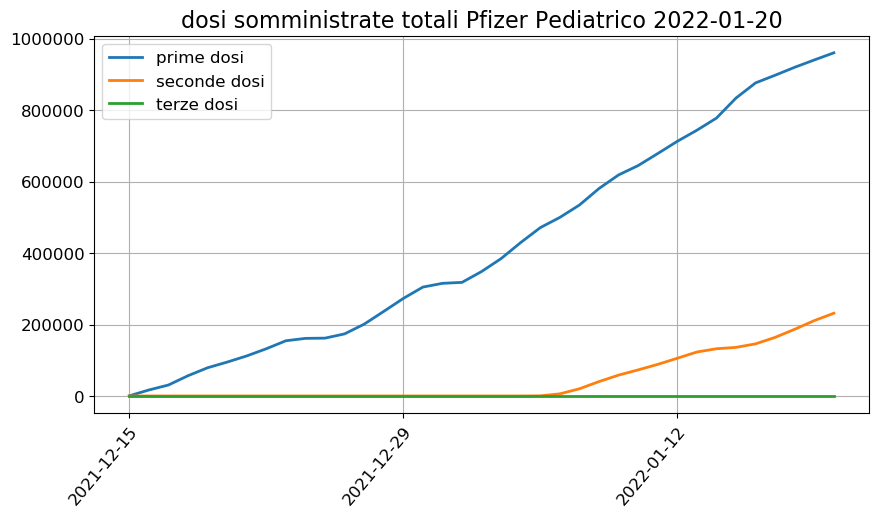

In [21]:
for fornitore in fornitori:
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot["totale_prima_dose"] = df_plot["prima_dose"].cumsum()
    df_plot["totale_seconda_dose"] = df_plot["seconda_dose"].cumsum()
    df_plot["totale_terza_dose"] = df_plot["terza_dose"].cumsum()
    savename_suffix="_"+fornitore.replace("/","_")    
    createXYPlot(df_plot, 
                 y=["totale_prima_dose","totale_seconda_dose","totale_terza_dose"],
                 labels=["prime dosi","seconde dosi", "terze dosi"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate totali {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate_totali_{savename_suffix}.png")

In [22]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag["fascia_anagrafica"]=="05-11"].tail(3)

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
3511            2022-01-18             05-11       22275         22715   
3521            2022-01-19             05-11       20468         24204   
3531            2022-01-20             05-11       20025         20654   

      terza_dose  pregressa_infezione  prima_dose_no_guariti  \
3511           0                   89                  22186   
3521           0                   72                  20396   
3531           0                   76                  19949   

      prima_dose_media_7  seconda_dose_media_7  terza_dose_media_7  
3511        34499.857143          14051.571429                 0.0  
3521        32535.142857          15056.142857                 0.0  
3531        30963.000000          15508.714286                 0.0

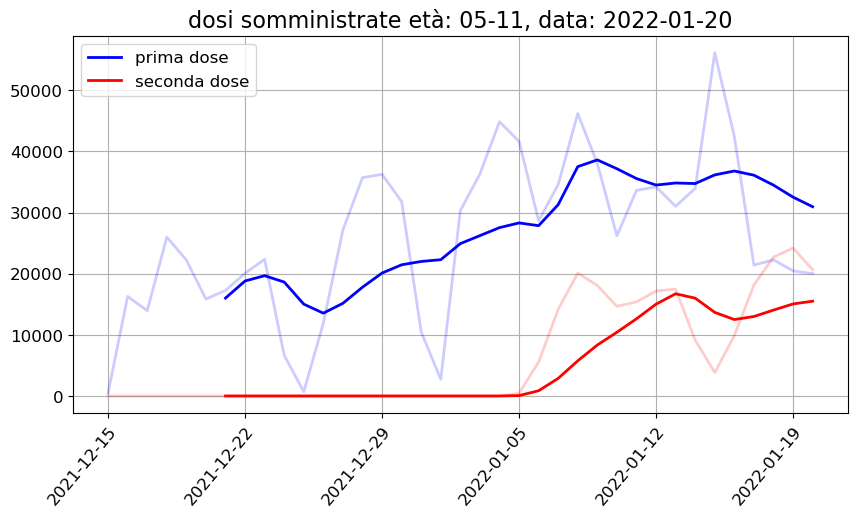

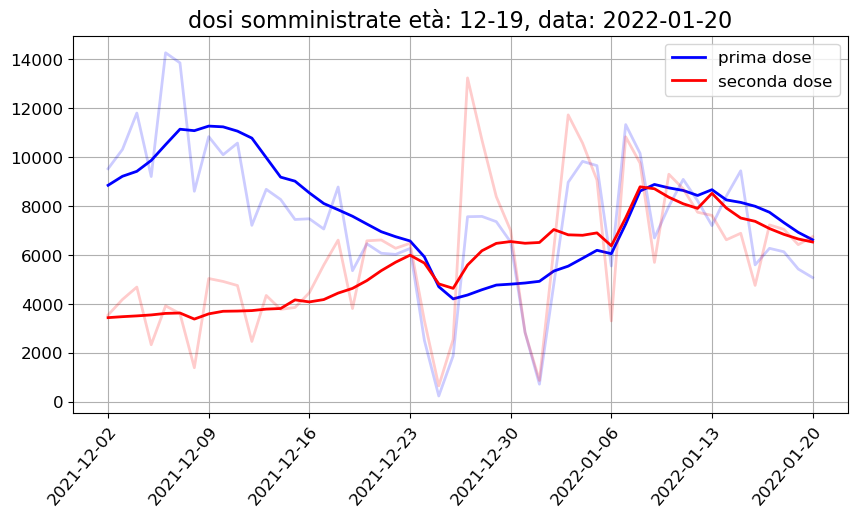

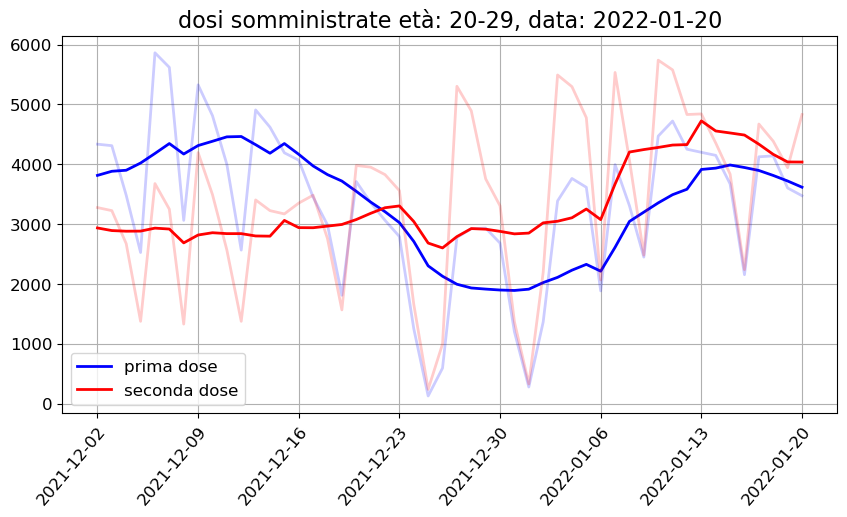

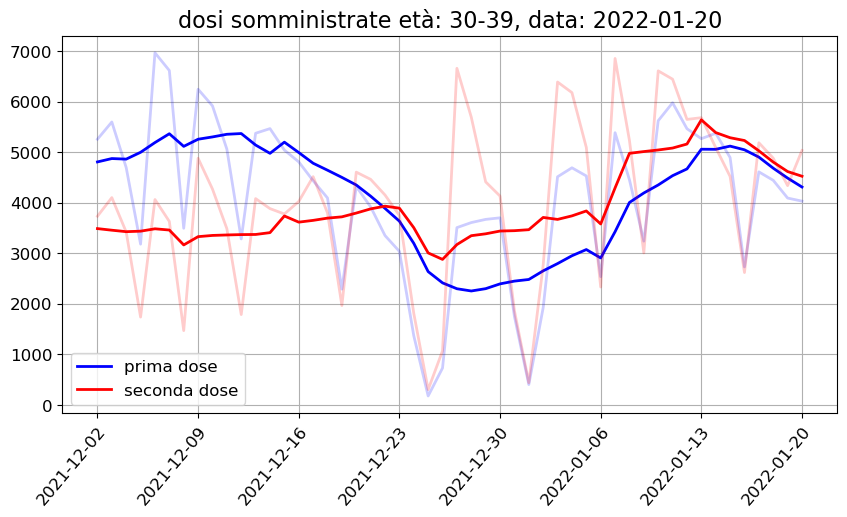

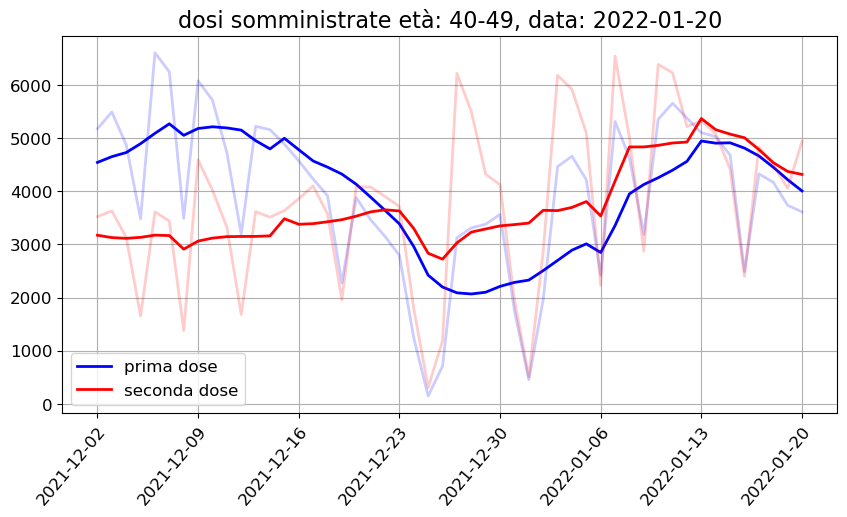

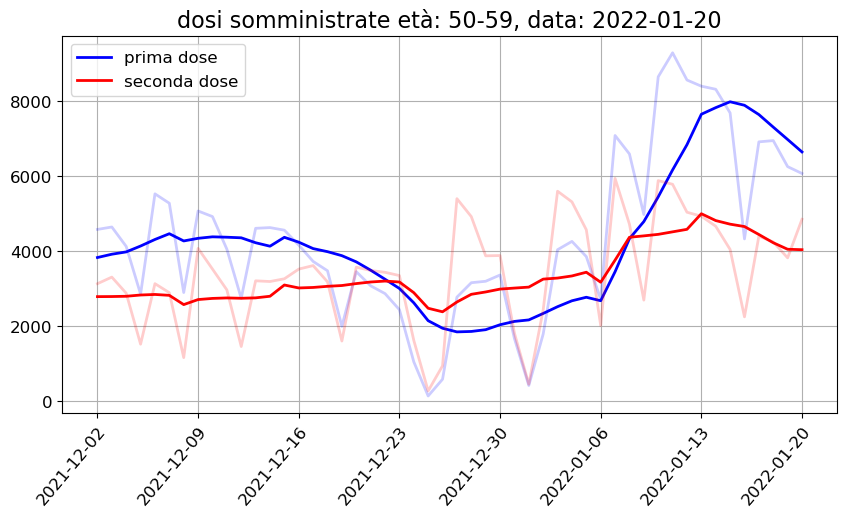

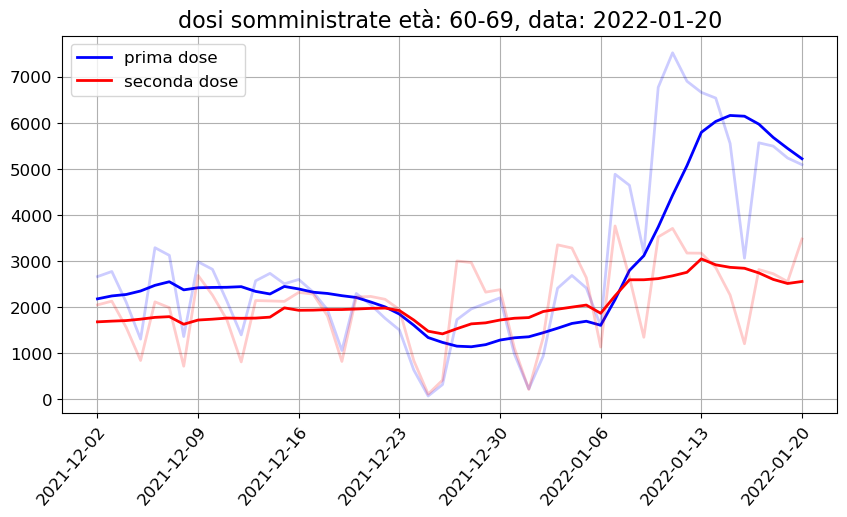

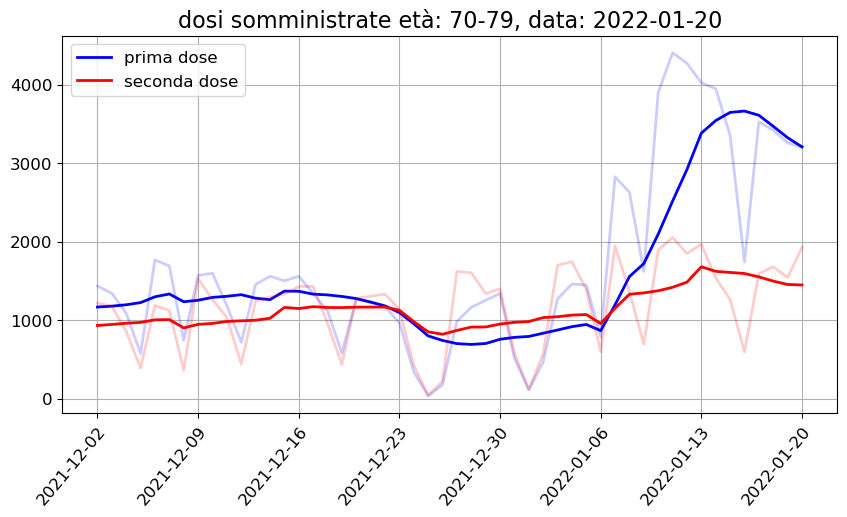

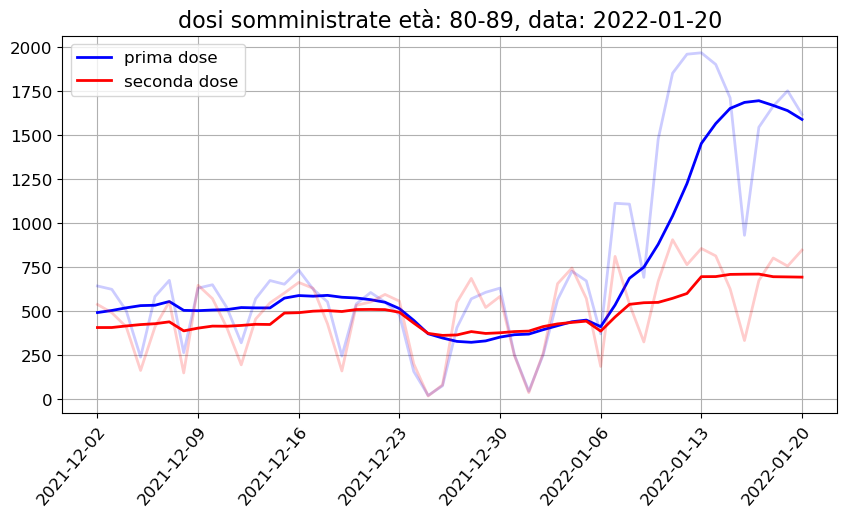

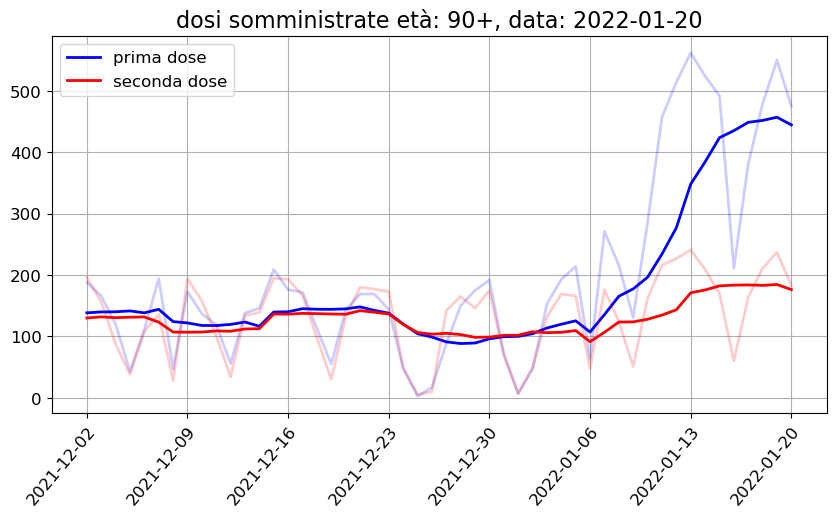

In [295]:
for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
    savename_suffix="_" + anag  
    df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    createXYPlot(df_plot, 
                 y=["prima_dose", "prima_dose_media_7", "seconda_dose", "seconda_dose_media_7"], 
                 labels=[None, "prima dose", None, "seconda dose"],
                 colors=["b","b","r","r"],
                 alphas=[0.2,1,0.2,1],
                 x="data_somministrazione", 
                 linewidth=2,
                 days_interval=7,
                 start_date="2021-12-01",
                 title=f"dosi somministrate età: {anag}, data: {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")


In [24]:
grid = get_grid(keys=["data_somministrazione","fascia_anagrafica"])

In [25]:
df_vax_yyyy_mm_dd_anag = grid.merge(df_vax_yyyy_mm_dd_anag, on=["data_somministrazione","fascia_anagrafica"], how="left")
df_vax_yyyy_mm_dd_anag = df_vax_yyyy_mm_dd_anag.fillna(0)

In [26]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.data_somministrazione=="2020-12-27"]

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
0            2020-12-27             05-11         0.0           0.0   
1            2020-12-27             12-19         0.0           0.0   
2            2020-12-27             20-29       704.0           0.0   
3            2020-12-27             30-39      1088.0           0.0   
4            2020-12-27             40-49      1508.0           0.0   
5            2020-12-27             50-59      2207.0           0.0   
6            2020-12-27             60-69      1513.0           0.0   
7            2020-12-27             70-79       130.0           0.0   
8            2020-12-27             80-89       118.0           0.0   
9            2020-12-27               90+        78.0           0.0   

   terza_dose  pregressa_infezione  prima_dose_no_guariti  prima_dose_media_7  \
0         0.0                  0.0                    0.0                 0.0   
1         0.0                  0.0                    0.0                 0.0   
2         0.0                  0.0                  704.0                 0.0   
3         0.0                  0.0                 1088.0                 0.0   
4         0.0                  2.0                 1506.0                 0.0   
5         0.0                  3.0                 2204.0                 0.0   
6         0.0                  5.0                 1508.0                 0.0   
7         0.0                  2.0                  128.0                 0.0   
8         0.0                  1.0                  117.0                 0.0   
9         0.0                  2.0                   76.0                 0.0   

   seconda_dose_media_7  terza_dose_media_7  
0                   0.0                 0.0  
1                   0.0                 0.0  
2                   0.0                 0.0  
3                   0.0                 0.0  
4                   0.0                 0.0  
5                   0.0                 0.0  
6                   0.0                 0.0  
7                   0.0                 0.0  
8                   0.0                 0.0  
9                   0.0                 0.0

In [27]:
def dosi_eta(media=True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for dose in ["prima","seconda","terza"]:
        plt.figure(dpi=100,figsize=(11,5))
        col_idx = 0
        for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
            df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
            df_plot = df_plot[df_plot.data_somministrazione>='2021-10-01']
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            if media:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=0.2, color=colors[col_idx])
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose_media_7"], label=anag, color=colors[col_idx], linewidth=2.0)
            else:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=1, label=anag, color=colors[col_idx])

            col_idx +=1
        plt.xticks(x, rotation=60, 
                   rotation_mode="anchor", 
                   verticalalignment = "top", 
                   horizontalalignment = "right",
                   fontsize=12
                  )
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend()
        if dose == "prima":
            title = "Prime dosi"
        elif dose == "seconda":
            title = "Seconde dosi"
        else:
            title = "Terze dosi"
        plt.title(f"{title} somministrate per fascia d'età",fontsize=16)
        savename=f"{plots_folder}/{dose}_dose_fascia_eta"
        if media:
            savename += "_media"
        plt.savefig(fname=f"{savename}.png",bbox_inches="tight")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


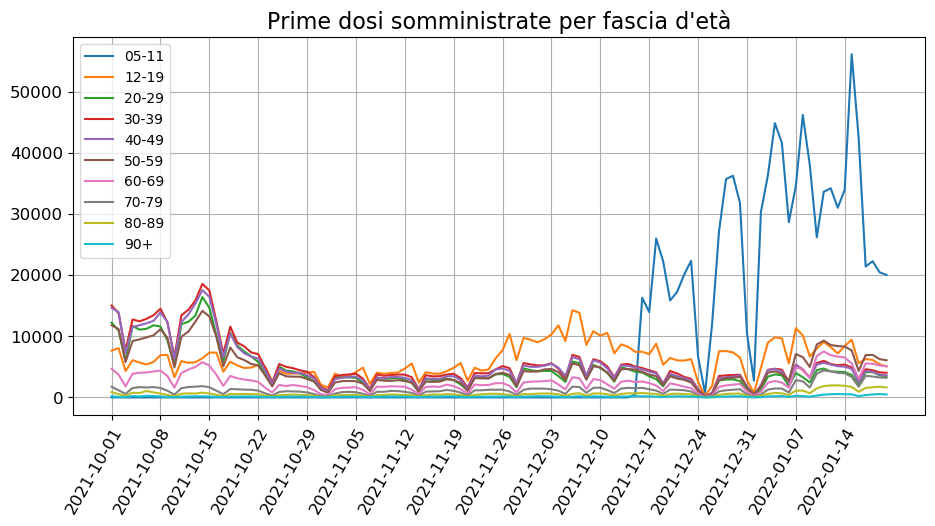

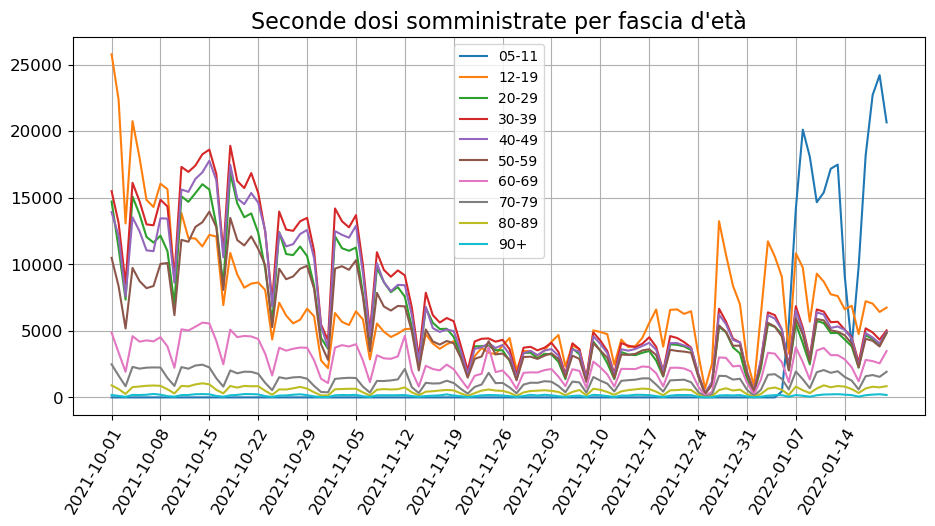

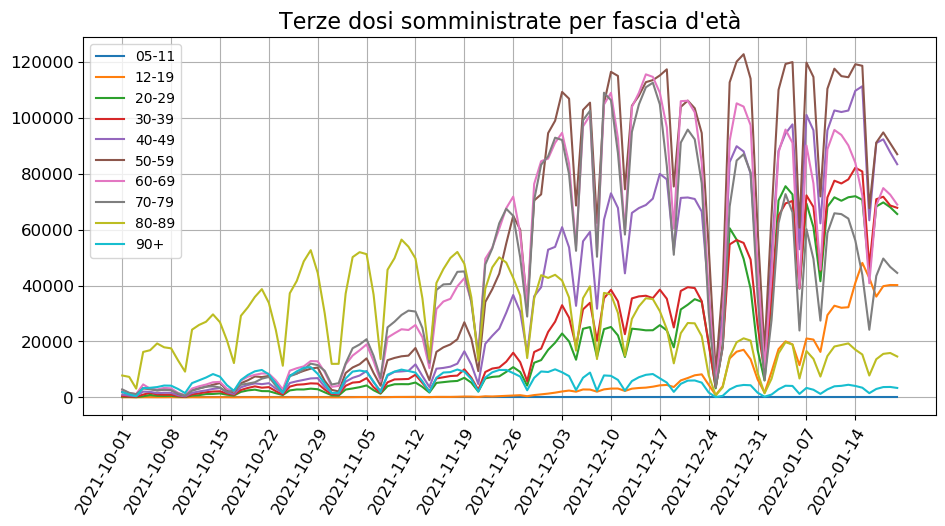

In [28]:
dosi_eta(media=False)

In [29]:
grid = get_grid(keys=["data_somministrazione", "fascia_anagrafica","fornitore"])

In [30]:
df_vax_yyyy_mm_dd_anag_fornitore = grid.merge(df_vax_yyyy_mm_dd_anag_fornitore, on=["data_somministrazione", "fascia_anagrafica","fornitore"],how="left")
df_vax_yyyy_mm_dd_anag_fornitore = df_vax_yyyy_mm_dd_anag_fornitore.fillna(0)

In [31]:
df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica=="05-11"]

data_somministrazione fascia_anagrafica                fornitore  \
0                2020-12-27             05-11                  Janssen   
1                2020-12-27             05-11                  Moderna   
2                2020-12-27             05-11        Pfizer Pediatrico   
3                2020-12-27             05-11          Pfizer/BioNTech   
4                2020-12-27             05-11  Vaxzevria (AstraZeneca)   
...                     ...               ...                      ...   
19450            2022-01-20             05-11                  Janssen   
19451            2022-01-20             05-11                  Moderna   
19452            2022-01-20             05-11        Pfizer Pediatrico   
19453            2022-01-20             05-11          Pfizer/BioNTech   
19454            2022-01-20             05-11  Vaxzevria (AstraZeneca)   

       prima_dose  seconda_dose  terza_dose  pregressa_infezione  \
0             0.0           0.0         0.0                  0.0   
1             0.0           0.0         0.0                  0.0   
2             0.0           0.0         0.0                  0.0   
3             0.0           0.0         0.0                  0.0   
4             0.0           0.0         0.0                  0.0   
...           ...           ...         ...                  ...   
19450         0.0           0.0         0.0                  0.0   
19451         0.0           0.0         0.0                  0.0   
19452     20025.0       20654.0         0.0                 76.0   
19453         0.0           0.0         0.0                  0.0   
19454         0.0           0.0         0.0                  0.0   

       prima_dose_no_guariti  prima_dose_media_7  seconda_dose_media_7  \
0                        0.0                 0.0              0.000000   
1                        0.0                 0.0              0.000000   
2                        0.0                 0.0              0.000000   
3                        0.0                 0.0              0.000000   
4                        0.0                 0.0              0.000000   
...                      ...                 ...                   ...   
19450                    0.0                 0.0              0.000000   
19451                    0.0                 0.0              0.000000   
19452                19949.0             30963.0          15508.714286   
19453                    0.0                 0.0              0.000000   
19454                    0.0                 0.0              0.000000   

       terza_dose_media_7  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
19450                 0.0  
19451                 0.0  
19452                 0.0  
19453                 0.0  
19454                 0.0  

[1950 rows x 11 columns]

In [32]:
def plot_anag_fornitore(start_date, media=False):
    for dose in ["prima","seconda","terza"]:
        for fornitore in fornitori:
            plt.figure(dpi=100, figsize=(10,4))
            max_val_0 = 0
            col_idx = 0
            for anag in anagrafiche:
                condizione = (df_vax_yyyy_mm_dd_anag_fornitore.fornitore == fornitore) & (df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag)
                df_plot = df_vax_yyyy_mm_dd_anag_fornitore[condizione]
                df_plot = df_plot[df_plot.data_somministrazione>=start_date]
                Xval = df_plot["data_somministrazione"]
                Yval = df_plot[f"{dose}_dose"]
                Yval_media7 = df_plot[f"{dose}_dose_media_7"]
                if media:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=0.15, color=colors[col_idx])
                    plt.plot(Xval, Yval_media7, label=anag, linewidth=2.0, color=colors[col_idx])
                else:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=1, color=colors[col_idx],label=anag)
                max_val = np.max(Yval)
                col_idx += 1
                if max_val > max_val_0:
                    max_val_0 = max_val
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            plt.xticks(x, rotation=60, 
                       rotation_mode="anchor", 
                       verticalalignment = "top", 
                       horizontalalignment = "right",
                       fontsize=12
                      )
            plt.yticks(fontsize=12)
            plt.grid()
            plt.legend()
            if dose == "prima":
                title = "Prime dosi"
            elif dose == "seconda":
                title = "Seconde dosi"
            else:
                title = "Terze dosi"
            title = f"{title} somministrate per fascia d'età"
            if media:
                title += ", media 7 giorni, "
            title += f" {fornitore}"
            savename = f"{plots_folder}/{dose}_dose_{fornitore.replace('/','_')}_eta"
            if media:
                savename += "_media7"
            savename += ".png"
            plt.title(title, fontsize=16)
            plt.savefig(fname=savename,bbox_inches="tight")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


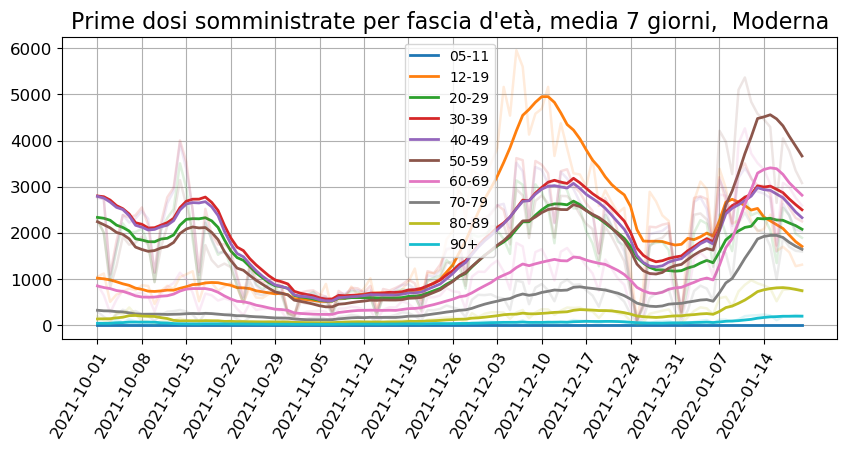

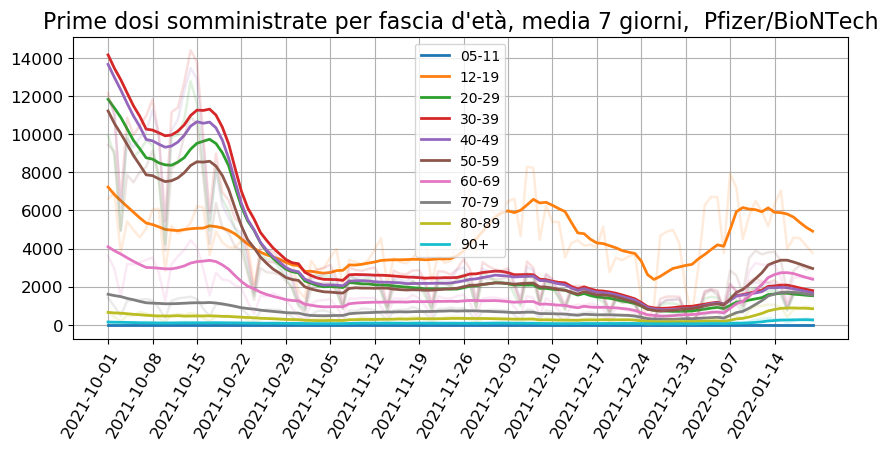

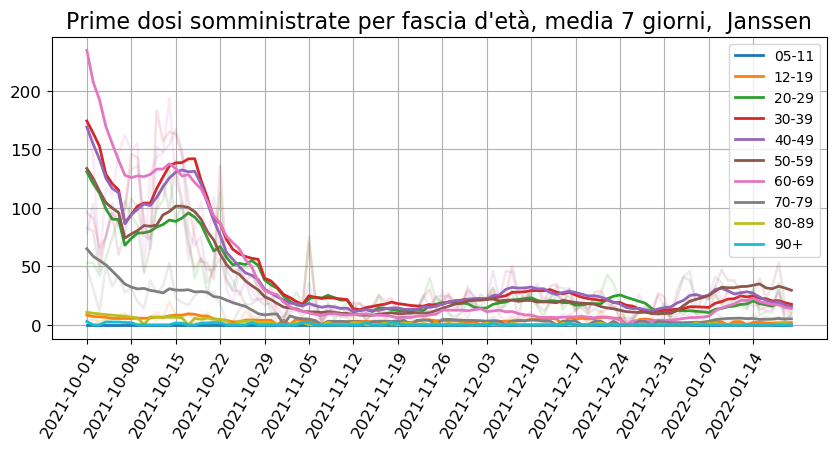

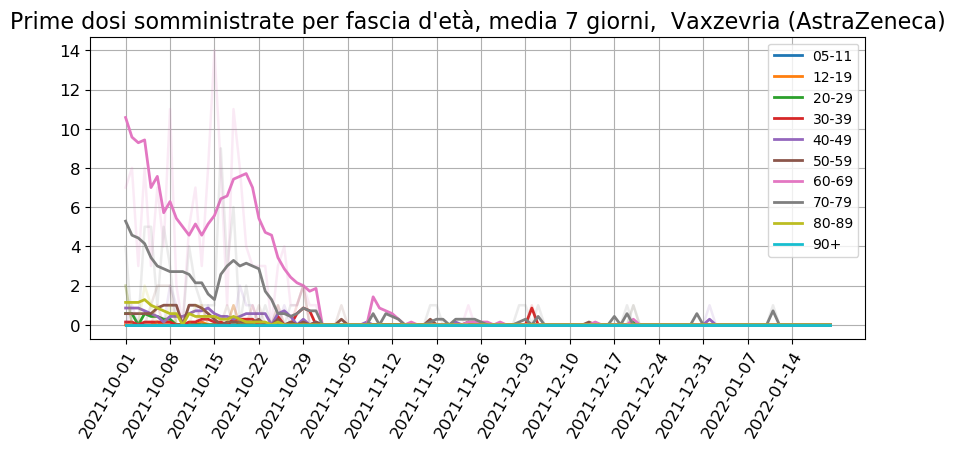

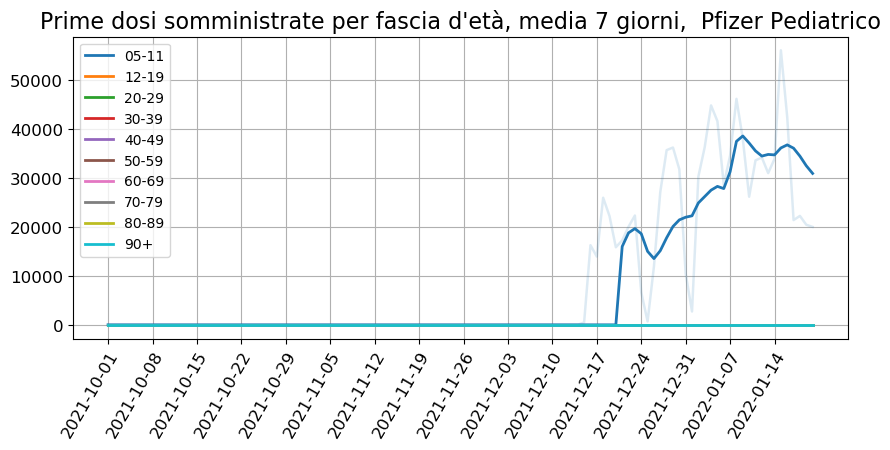

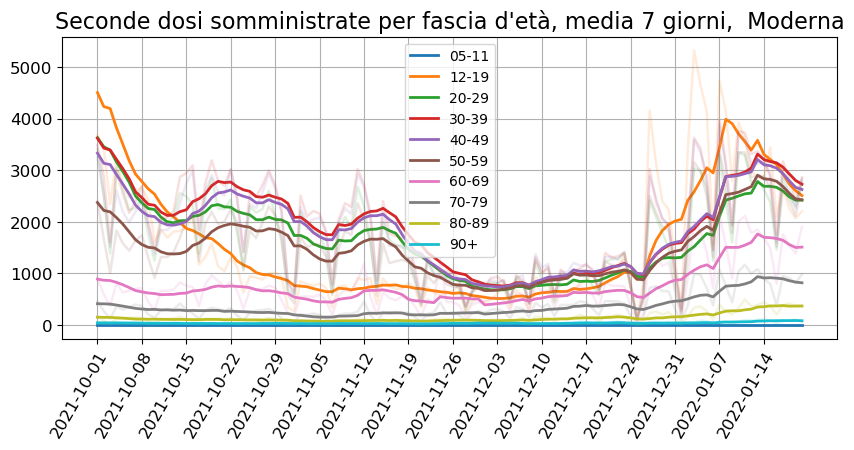

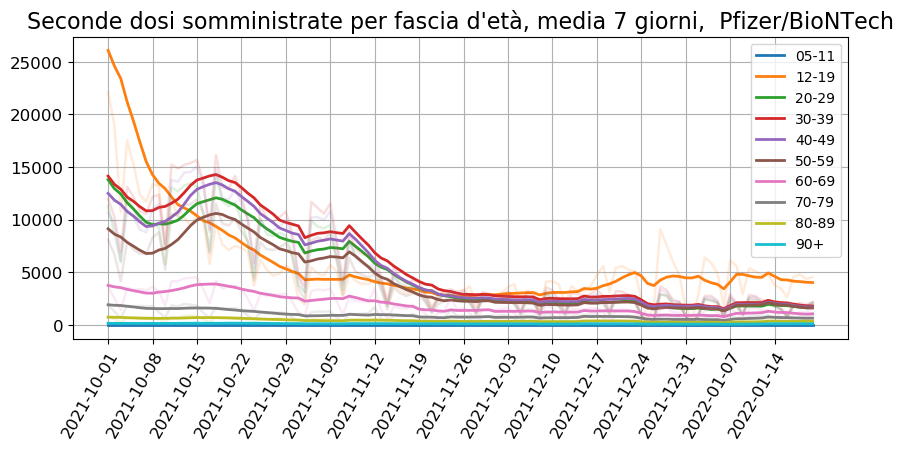

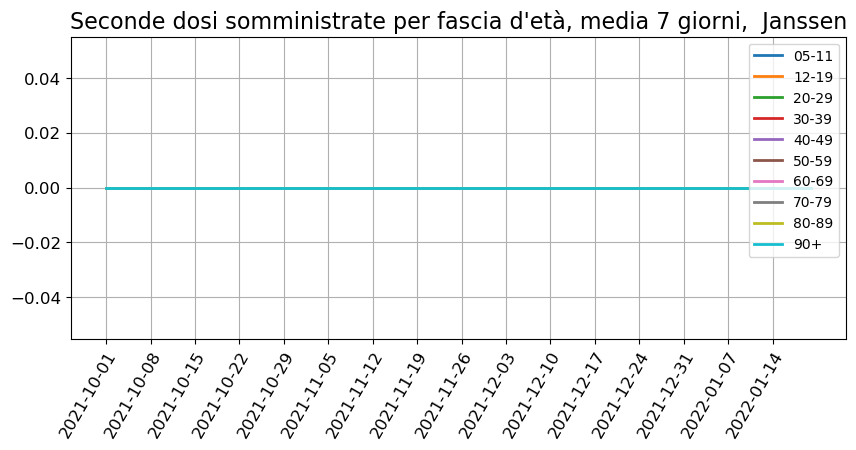

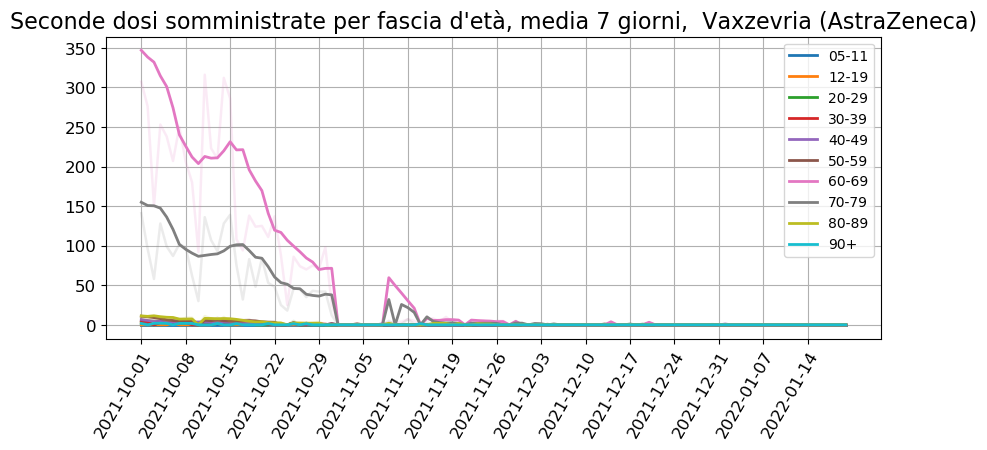

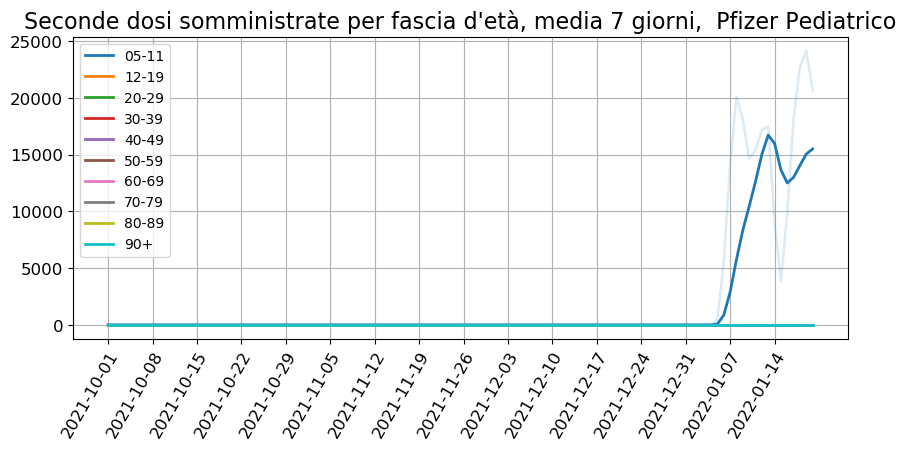

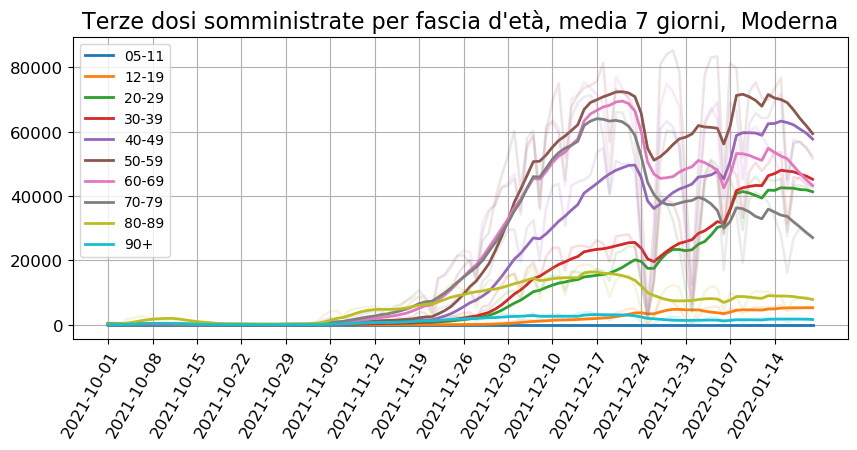

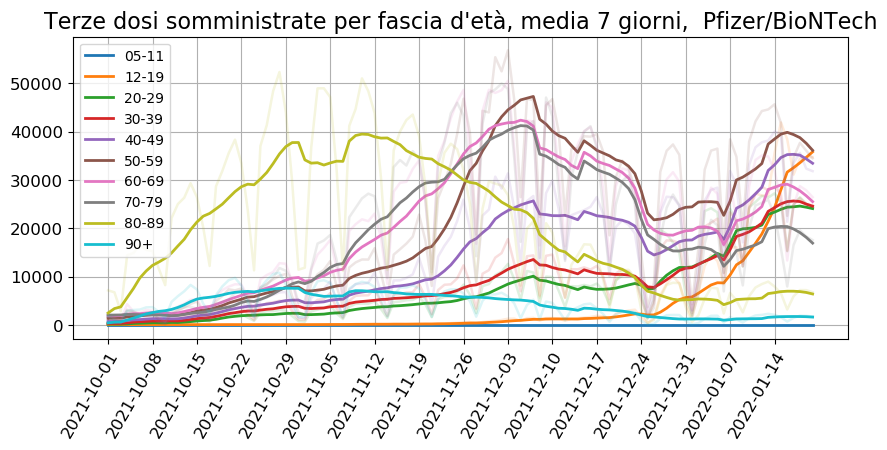

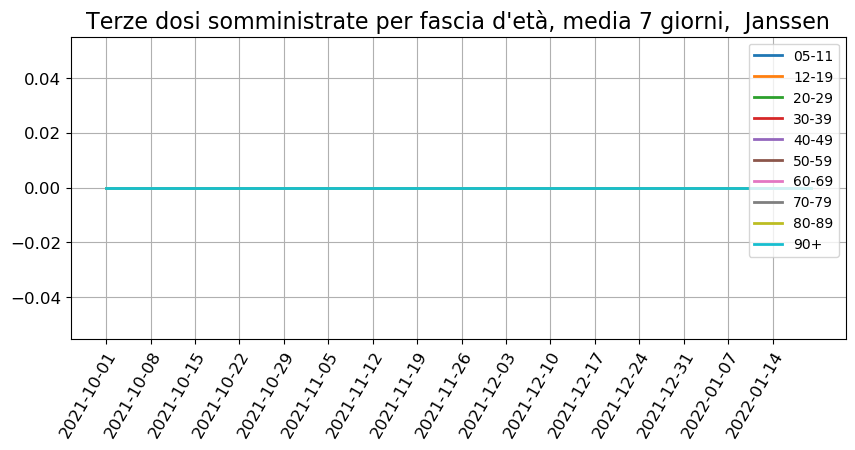

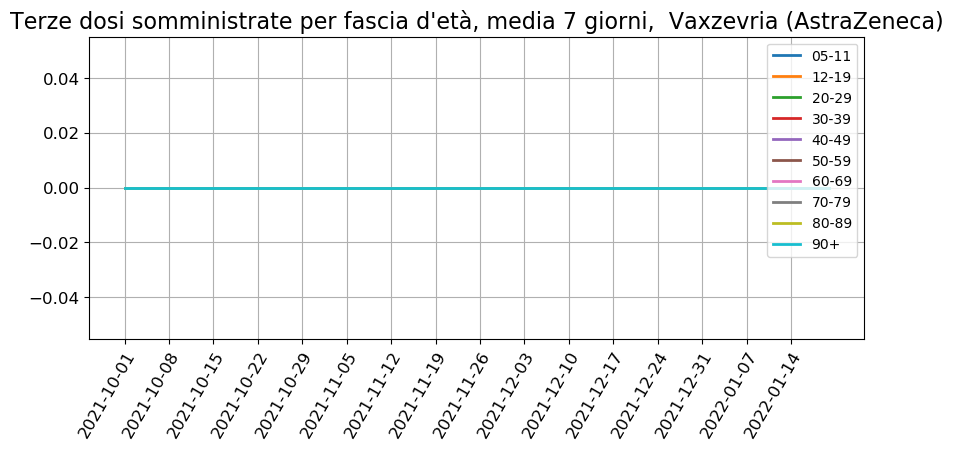

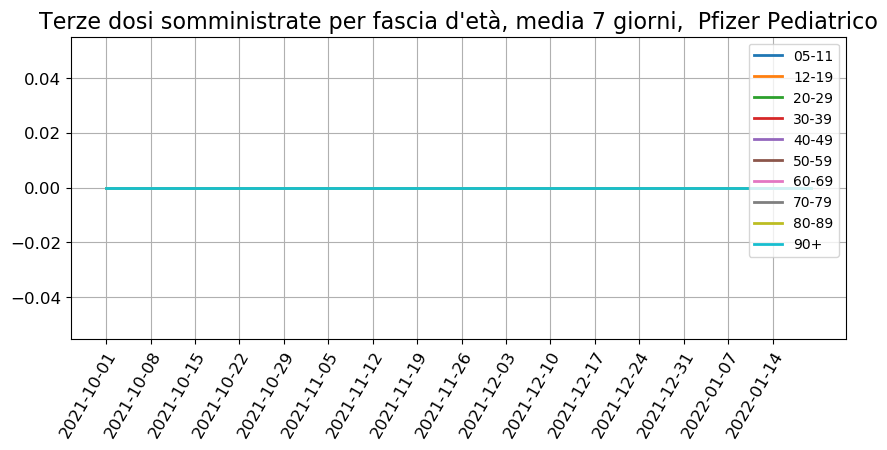

In [33]:
plot_anag_fornitore(start_date="2021-10-01", media=True)

In [344]:
popolazione = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/platea.csv")
popolazione = popolazione.groupby("fascia_anagrafica").sum().reset_index()

In [349]:
pop_over_50 = popolazione[popolazione.fascia_anagrafica.isin(["50-59","60-69","70-79","80+"])]
display(pop_over_50)
np.sum(pop_over_50["totale_popolazione"])

fascia_anagrafica  totale_popolazione
5             50-59             9645613
6             60-69             7552718
7             70-79             6018697
8               80+             4574312

27791340

In [356]:
prime_dosi_over_50 = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])][["data_somministrazione","fascia_anagrafica","prima_dose"]]
np.sum(prime_dosi_over_50["prima_dose"])

25751403

In [358]:
prime_dosi_over_50

data_somministrazione fascia_anagrafica  prima_dose
3               2020-12-27             50-59        2207
4               2020-12-27             60-69        1513
5               2020-12-27             70-79         130
6               2020-12-27             80-89         118
7               2020-12-27               90+          78
...                    ...               ...         ...
3536            2022-01-20             50-59        6074
3537            2022-01-20             60-69        5093
3538            2022-01-20             70-79        3203
3539            2022-01-20             80-89        1617
3540            2022-01-20               90+         475

[1948 rows x 3 columns]

In [357]:
27791340-25751403

2039937